# Homework 5
## Rui Fang $\quad$ Collaborator: Yudi (Judy) Wang
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 2nd, 2018 at 11:00am

**Instructions:**

- Upload your final answers in a Jupyter notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

## Problem 1: Optimization (contd)

Suppose you are building a pricing model for laying down telecom cables over a geographical region. Your model takes as input a pair of  coordinates, $(x, y)$, and contains two parameters, $\lambda_1, \lambda_2$. Given a coordinate, $(x, y)$, and model parameters, the loss in revenue corresponding to the price model at location $(x, y)$ is described by
$$
L(x, y, \lambda_1, \lambda_2) = 0.000045\lambda_2^2 y - 0.000098\lambda_1^2 x  + 0.003926\lambda_1 x\exp\left\{\left(y^2 - x^2\right)\left(\lambda_1^2 + \lambda_2^2\right)\right\}
$$
Read the data contained in `HW3_data.csv`. This is a set of coordinates configured on the curve $y^2 - x^2 = -0.1$. Given the data, find parameters $\lambda_1, \lambda_2$ that minimize the net loss over the entire dataset.

### Simulated Annealing 
Implement Simulated Annealing initalized at $(\lambda_1, \lambda_2) = (-5, 0)$ to minimize our loss function $L$. Compare your results to what you obtained for gradient descent and stochastic gradient descent initialized at $(\lambda_1, \lambda_2) = (-5, 0)$.

For your Simulated Annealing implementation, we suggest *starting* with following settings for parameters (you should further experiment with and tweak these or feel free to set your own):

- Proposal distribution: bivariate normal with covariance $[[1, 0], [0, 1]]$
- Min Length: 500
- Max Temperature: 10

You should also set your own cooling schedule.

For each temperature, plot the parameters accepted or the cost function with respect to the iteration number. What is happening to the these parameters or costs over iterations? Connect the trends you observe in the visualization to the lecture on Markov Chains.

***

## Solution

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from functools import partial
import math
import seaborn as sns

%matplotlib notebook

sns.set()

In [47]:
# Function to do simulated annealing (adapted from example code given in lecture)
def sa(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    accumulator = []
    best_solution = old_solution = initials['solution']
    T = initials['T']
    length = initials['length']
    best_energy = old_energy = energyfunc(old_solution)
    accepted = 0
    total = 0
    
    for index in range(epochs):
        
        if index > 0:
            T = tempfunc(T)
            length = iterfunc(length)
        
        print("Epoch", index, "Temperature", T, "Length", length)
        
        for it in range(length):
            total += 1
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                
                # Accept proposed solution
                accepted += 1
                accumulator.append((T, new_solution, new_energy))
                
                if new_energy < best_energy:
                    
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index = total
                    best_temp = T
                
                old_energy = new_energy
                old_solution = new_solution
            
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
    
    best_meta = dict(index=best_index, temp=best_temp)
    print("\nfrac accepted", accepted/total, "\ntotal iterations", total, '\nbmeta', best_meta)
    
    return best_meta, best_solution, best_energy, accumulator

In [53]:
# Load in data
data = np.loadtxt('HW3_data.csv', delimiter=',')
X, Y = data[0,:], data[1,:]

# Energy function 
L = lambda lmd: np.sum(0.000045*lmd[1]**2*Y - 0.000098*lmd[0]**2*X + 
                       0.003926*lmd[0]*X*np.exp((Y**2-X**2)*(lmd[0]**2+lmd[1]**2)))

# Proposal function
pf = partial(np.random.multivariate_normal, cov=[[1, 0], [0, 1]])

# Temperature function
tf = lambda t: 0.8*t  

# Iteration function
itf = lambda length: math.ceil(1.2*length)

# Initials
inits = dict(solution=[-5,0], length=500, T=10)

bmeta, bs, be, out = sa(energyfunc=L, 
                        initials=inits, 
                        epochs=20, 
                        tempfunc=tf, 
                        iterfunc=itf, 
                        proposalfunc=pf)

Epoch 0 Temperature 10 Length 500
Epoch 1 Temperature 8.0 Length 600
Epoch 2 Temperature 6.4 Length 720
Epoch 3 Temperature 5.120000000000001 Length 864
Epoch 4 Temperature 4.096000000000001 Length 1037
Epoch 5 Temperature 3.276800000000001 Length 1245
Epoch 6 Temperature 2.621440000000001 Length 1494
Epoch 7 Temperature 2.097152000000001 Length 1793
Epoch 8 Temperature 1.6777216000000008 Length 2152
Epoch 9 Temperature 1.3421772800000007 Length 2583
Epoch 10 Temperature 1.0737418240000005 Length 3100
Epoch 11 Temperature 0.8589934592000005 Length 3720
Epoch 12 Temperature 0.6871947673600004 Length 4464
Epoch 13 Temperature 0.5497558138880003 Length 5357
Epoch 14 Temperature 0.4398046511104003 Length 6429
Epoch 15 Temperature 0.3518437208883203 Length 7715
Epoch 16 Temperature 0.28147497671065624 Length 9258
Epoch 17 Temperature 0.22517998136852502 Length 11110
Epoch 18 Temperature 0.18014398509482002 Length 13332
Epoch 19 Temperature 0.14411518807585602 Length 15999

frac accepted 0.2

In [59]:
print('Solution: L=%.3f at (lambda_1, lambda_2) = (%.3f, %.3f)' % (be, bs[0], bs[1]))

Solution: L=-9.934 at (lambda_1, lambda_2) = (2.057, 0.006)


With simulated annealing initialized at $(\lambda_1, \lambda_2) = (-5, 0)$, we find the minimum $L=-9.934$ at $(\lambda_1, \lambda_2) = (2.057, 0.006)$, which is close to the known global minimum. For gradient descent and stochastic gradient descent, when initialized at $(\lambda_1, \lambda_2) = (-5, 0)$, both algorithms are only able to find the local minimum $L=8.16$ at $(\lambda_1, \lambda_2) = (-5.36325804, 0)$. Therefore simulated annealing works better in this case.

<IPython.core.display.Javascript object>


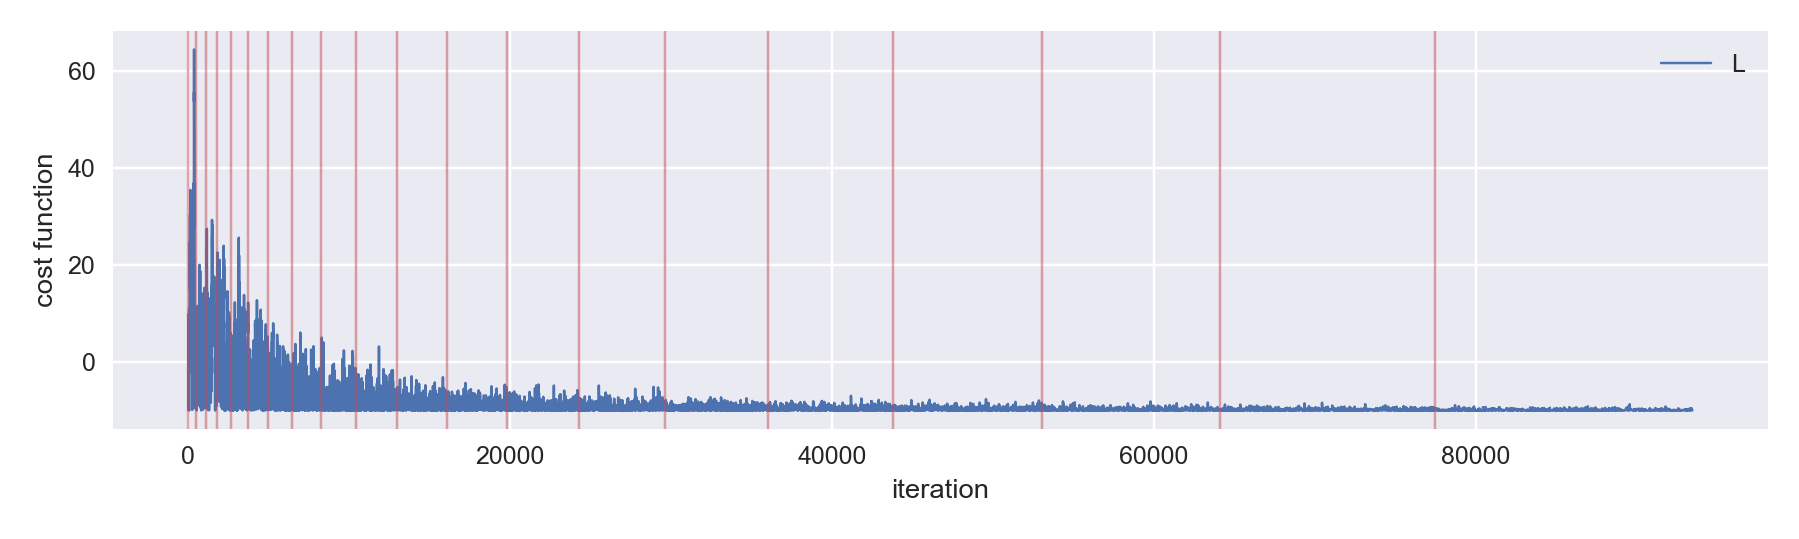

<IPython.core.display.Javascript object>


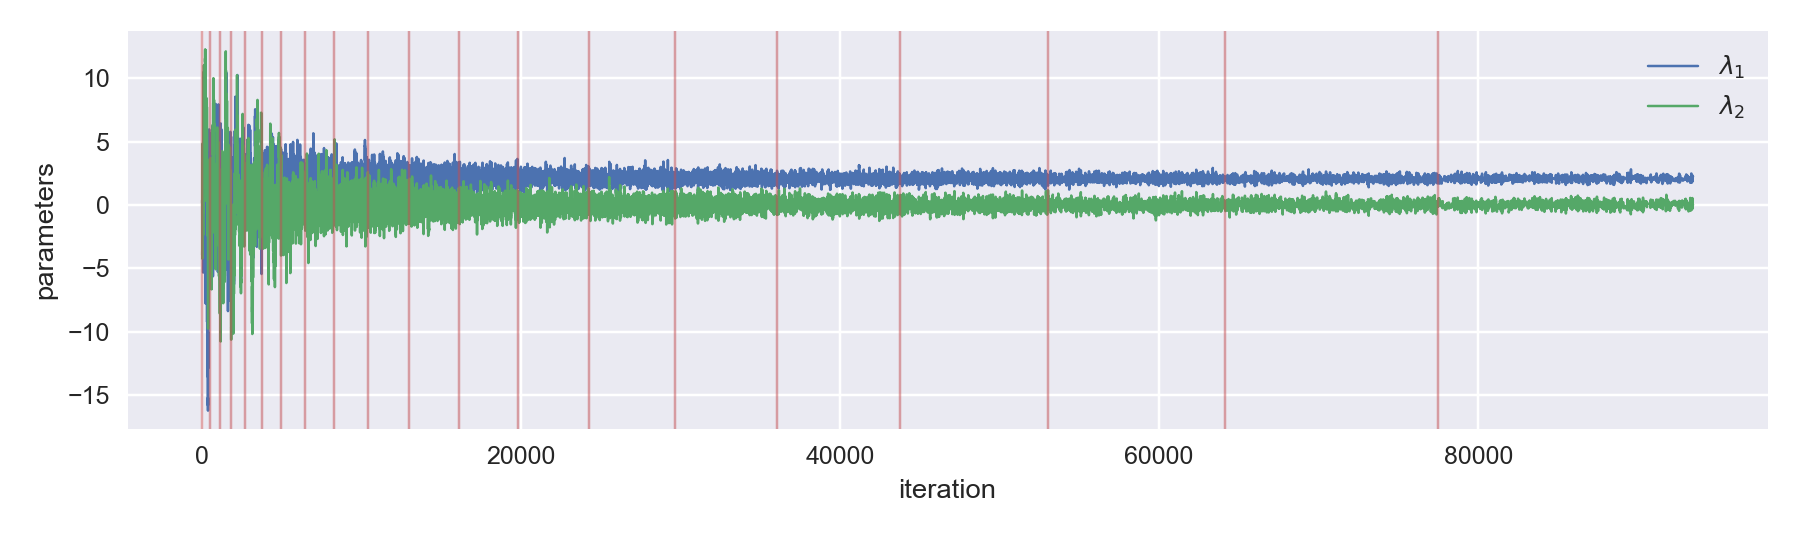

In [60]:
# Plot cost function and parameters vs iterations 
all_T = np.array([e[0] for e in out])
all_solution = np.array([e[1] for e in out])
all_energy = np.array([e[2] for e in out])

Ts, indices = np.unique(all_T, return_index=True)  # for plotting when the temperature changes 

plt.figure(figsize=(10,3))
plt.plot(all_energy, lw=1, label='L')
for idx in indices:
    plt.axvline(x=idx, color='C2', alpha=0.5, lw=1)  # plot vertical lines to indicate temperature changes
plt.xlabel('iteration')
plt.ylabel('cost function')
# plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,3))
plt.plot(all_solution[:,0], lw=1, label=r'$\lambda_1$')
plt.plot(all_solution[:,1], lw=1, label=r'$\lambda_2$')
for idx in indices:
    plt.axvline(x=idx, color='C2', alpha=0.5, lw=1)  # plot vertical lines to indicate temperature changes
plt.xlabel('iteration')
plt.ylabel('parameters')
# plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

According to the graphs, the cost function and the parameters converge to the optimal solution with less and less fluctuations over iterations. This is as expected because when the temperature is decreased, we get a tighter distribution around the global minimum. 

***

## Problem 2: A Tired Salesman

In the famous traveling salesman problem, the quality of the solution can be measured in 
different ways, beyond finding the shortest path.  For example, the total time of travel may also be important, and may depend on the means of transportation that connect pairs of 
cities.  Consider a random distribution of $N$ points on a plane representing the cities 
that must be visited by the traveling salesman.  Each point is an (x,y) coordinate where both x and y are integers in the range $[1, 50)$. Assign a value $s_i$ where $i\in [1,\dots,N]$ to each city that represents its size measured by population.  Let $\forall s_i, \  s_i \in [1, 10)$.  If two cities are farther away from each other than a **distance threshold of 10** and both have populations greater than a **population threshold of 5** assume there is a flight connection between them.  In all other cases assume that our poor salesman would have to drive between cities. Flying is faster than driving by a factor of 10. 

1. Use Simulated Annealing to find solutions to the traveling salesman problem for $N=100$, optimizing the travel path for the total distance travelled (but keeping track of the time of travel). 

2. Now redo the problem by optimizing the the path for the total time of travel (but keeping track of the distance traveled). Are the two solutions similar or different? 

3. How do your results change if the population and distance thresholds for the exisitence of a flight between two cities are altered?


***
## Solution

In [6]:
## The tsp code is adapted from code given in lab5 

## for TSP material
import random
import time
import itertools
import urllib
import csv
import functools
from statistics import mean, stdev
import math
from collections import namedtuple

In [34]:
# Cities are represented as Points, which are a subclass of complex numbers
City = namedtuple('City', ['x', 'y', 'population'], verbose=False)

def distance(A, B): 
    "The distance between two points."
    return math.sqrt((A.x - B.x)*(A.x - B.x) + (A.y - B.y)*(A.y - B.y))

def traveltime(A, B, distance_threshold, population_threshold):
    "The travel time between two points."
    speed = 1. 
    distanceAB = distance(A, B)
    if distanceAB > distance_threshold:
        if (A.population > population_threshold) and (B.population > population_threshold):
            speed = 10.
    return distanceAB/speed

def tour_length(tour):
    "The total of distances between each pair of consecutive cities in the tour."
    return sum(distance(tour[i], tour[i-1]) for i in range(len(tour)))

def tour_time(tour, distance_threshold=10, population_threshold=5):
    "The total travel time in the tour."
    return sum(traveltime(tour[i], tour[i-1], distance_threshold, population_threshold) 
               for i in range(len(tour)))

def Cities(n, width=50, height=50, maxsize=10, seed=42):
    """
    Make a set of n cities, each with random coordinates in range [1, width) and [1, height) and with random 
    population size in range [1, maxsize). 
    """
    random.seed(seed * n)
    return frozenset(City(random.randrange(1, width), random.randrange(1, height), random.uniform(1, maxsize))
                     for c in range(n))

def plot_lines(points, marker='o', color='b', lw=1):
    "Plot lines to connect a series of points."
    plt.plot([p.x for p in points], [p.y for p in points], c=color, lw=lw, zorder=1)
    plt.scatter([p.x for p in points], [p.y for p in points], 
                s=[10*p.population for p in points], marker=marker, c=color, zorder=2)
    plt.axis('scaled') 
    plt.axis('off')

def plot_tour(tour):
    "Plot the cities as circles and the tour as lines between them. Start city is red square."
    start = tour[0]
    plot_lines(list(tour) + [start])
    plot_lines([start], marker='s', color='r')  # Mark the start city with a red square
    
def plot_tsp(tour, cities, tour_time_func=tour_time):
    "Apply a TSP algorithm to cities, plot the resulting tour, and print information."
    
    assert valid_tour(tour, cities)
    plot_tour(tour)
    plt.title("{} city tour with length {:.1f} and travel time {:.1f}"
              .format(len(tour), tour_length(tour), tour_time_func(tour)))

def valid_tour(tour, cities):
    "Is tour a valid tour for these cities?"
    return set(tour) == set(cities) and len(tour) == len(cities)

def change_tour(input_tour):
    "Change a tour for tsp iteration"
    
    #possible_indices = range(1, len(input_tour)) why not?
    possible_indices = range(len(input_tour))
    
    # take two random indices to swap
    c1 = np.random.choice(possible_indices)
    c2 = np.random.choice(possible_indices)
    
    new_tour = change_path(input_tour, c1, c2)
    
    return new_tour

def swap_cities(input_tour, i, j):
    "Swap two cities at index i and j in a tour"
    
    # save city1
    city1 = input_tour[i]
    
    # save city2
    city2 = input_tour[j]
    
    new_tour = input_tour.copy()
    
    # swap
    new_tour[j] = city1
    new_tour[i] = city2
        
    return new_tour

def reverse_segment(input_tour, i, j):
    "Reverse segment tour[i:j] of a tour"
    
    new_tour = input_tour.copy()
    new_tour[min(i,j):max(i,j)+1] = reversed(input_tour[min(i,j):max(i,j)+1])
    
    return new_tour
    
change_path = reverse_segment

In [8]:
# We've constructed our own simulated annealing function for tsp but we don't
# really need to make any changes.  So we'll just comment the regular sa :-)
def sa_tsp(energyfunc, initials, epochs, tempfunc, iterfunc, proposalfunc):
    """
    Run simulated annealing on a tsp.
    """
    # Accumulate results in the same form as initals
    accumulator = []
    
    # Our initial state is in initials['solution']
    best_solution = old_solution = initials['solution']
    
    # Our initial temperature is in initials['T']
    T = initials['T']
    
    # Our initial length (i.e. number of iterations per epoch)
    # is in initals['length']
    length = initials['length']
    
    # initialize the energy of our current state by running the 
    # energy function on our initial solution
    best_energy = old_energy = energyfunc(old_solution)
    
    # keep track of accepted proposals and total iterations
    accepted = 0
    total = 0
    
    for index in range(epochs):
        #print("Epoch", index)
        
        # if we're past the first index, we need
        # to update our cooling schedule and iteration
        # schedule
        if index > 0:
            T = tempfunc(T)
            length = iterfunc(length)
            
#         if index % 100 == 0:
#             print("Epoch", index, "Temperature", T, "Length", length)
        
        # run through the iterations for each epoch
        for it in range(length):
            
            # keep track of total proposals
            total += 1
            
            # get a new proposal and calculate its energy
            new_solution = proposalfunc(old_solution)
            new_energy = energyfunc(new_solution)
            
            # Use a min here as you could get a "probability" > 1
            alpha = min(1, np.exp((old_energy - new_energy)/T))
            if ((new_energy < old_energy) or (np.random.uniform() < alpha)):
                
                # Accept proposed solution
                accepted += 1.0
                accumulator.append((T, new_solution, new_energy))
                
                # we have a new candidate for optimum (minimum)
                if new_energy < best_energy:
                    # Replace previous best with this one
                    best_energy = new_energy
                    best_solution = new_solution
                    best_index = total
                    best_temp = T
                    
                old_energy = new_energy
                old_solution = new_solution
            else:
                # Keep the old stuff
                accumulator.append((T, old_solution, old_energy))
    
    best_meta = dict(index=best_index, temp=best_temp)
    print("\nfrac accepted", accepted/total, "\ntotal iterations", total, '\nbmeta', best_meta)
    return best_meta, best_solution, best_energy, accumulator

<IPython.core.display.Javascript object>


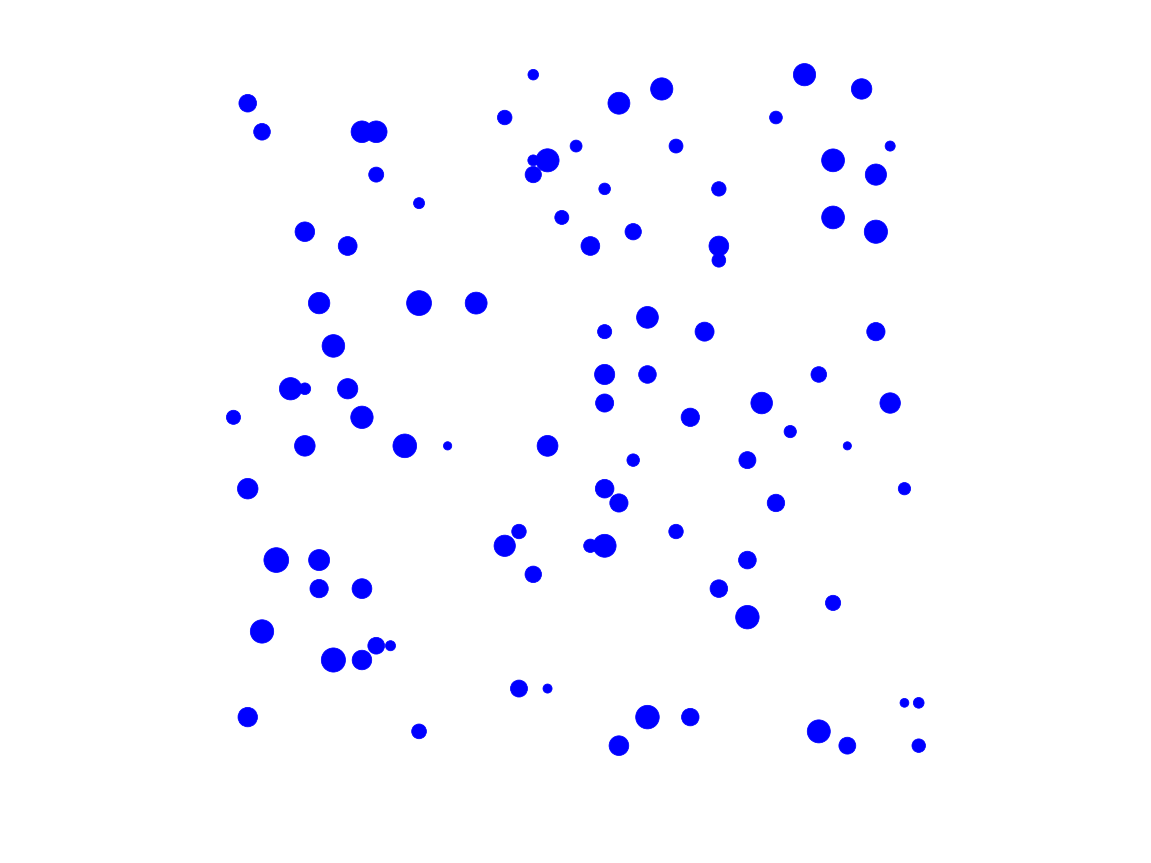

In [9]:
N = 100
mycities = Cities(N, seed=207)
plt.figure()
plot_lines(mycities, lw=0)
plt.tight_layout()
plt.show()

In [24]:
length_func = lambda length: max(int(math.ceil(1.2*length)), 10)
temp_func = lambda t: 0.8*t

initial_tour = list(mycities)
init_length = 100
inits = dict(solution=initial_tour, length=init_length, T=100.0)

### 1.Optimizing the travel path for the total distance travelled


frac accepted 0.04041700214707461 
total iterations 119232 
bmeta {'index': 73653, 'temp': 0.24178516392292618}


<IPython.core.display.Javascript object>


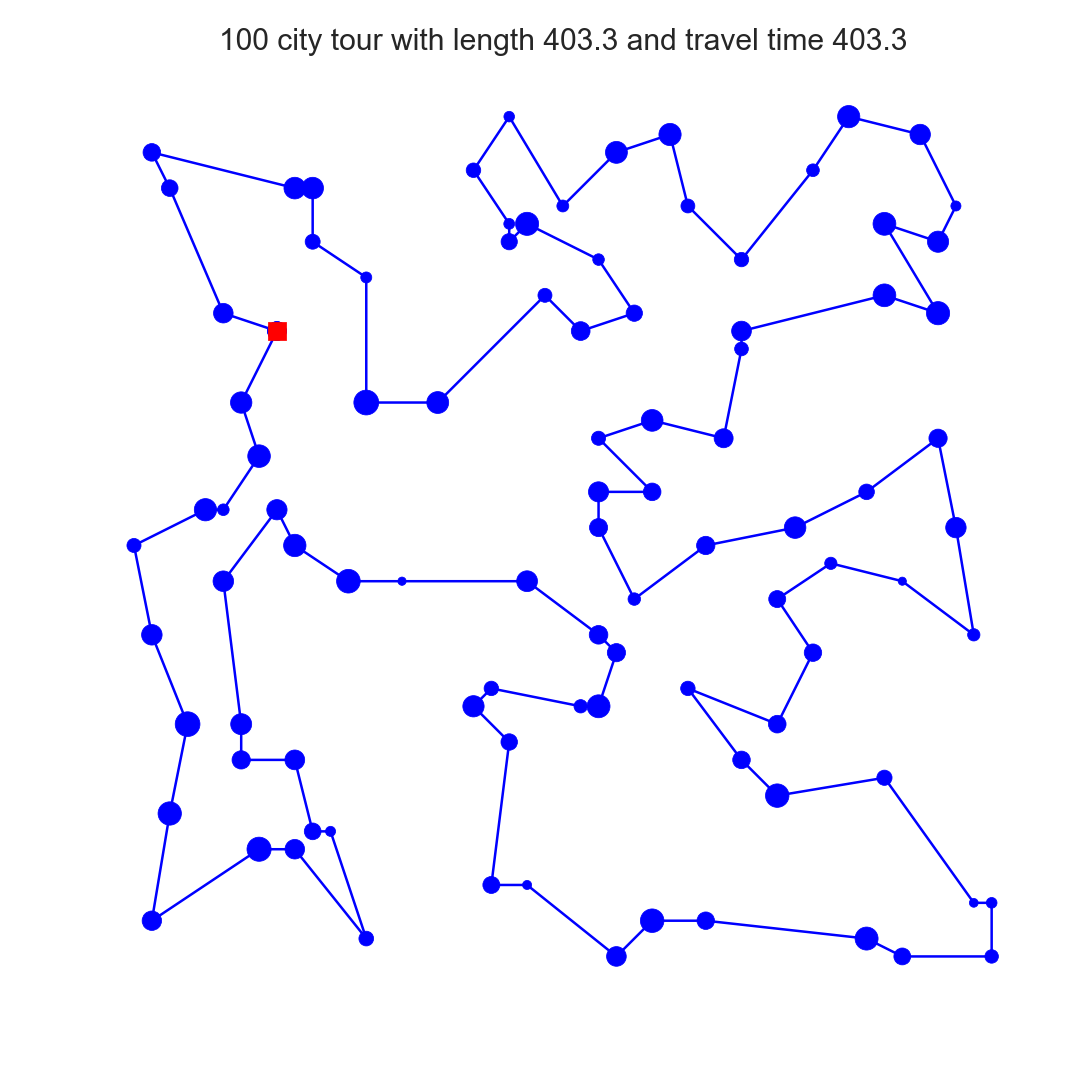

<IPython.core.display.Javascript object>


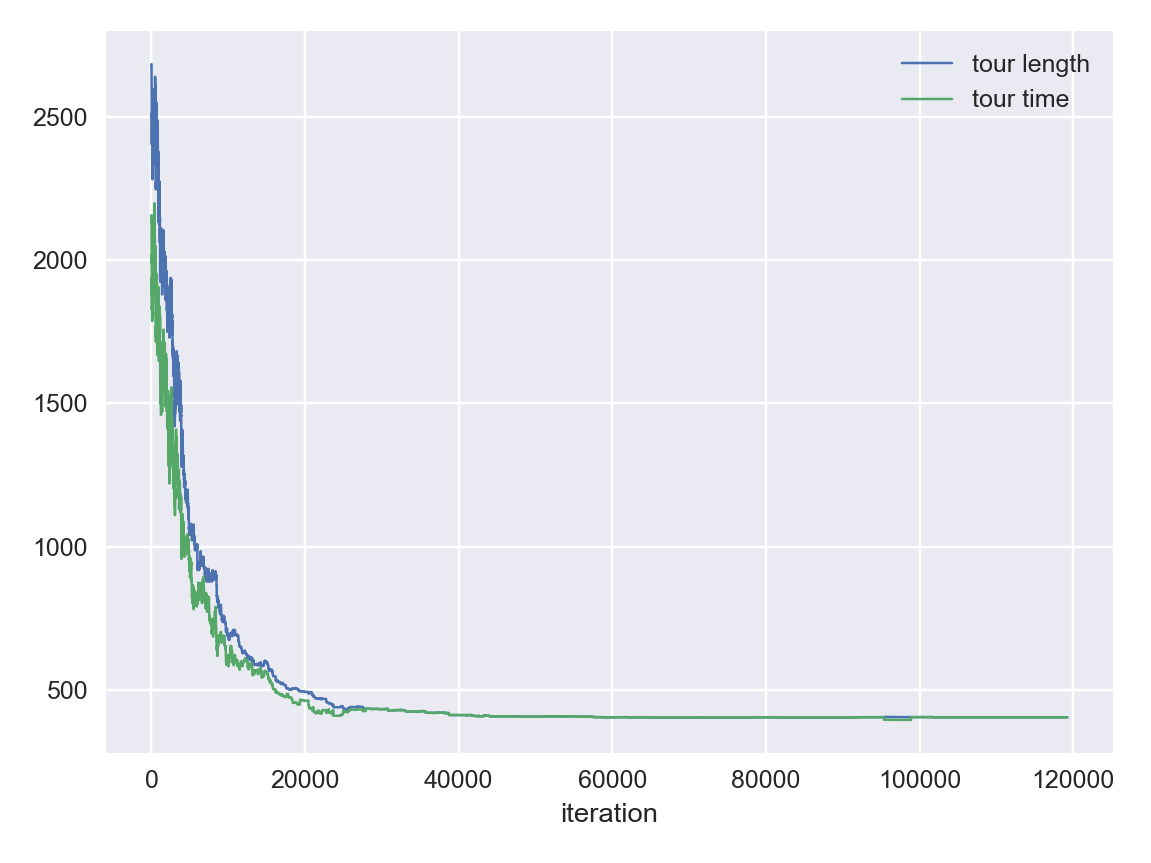

In [25]:
bmeta, bs, be, out = sa_tsp(tour_length, inits, 30, temp_func, length_func, change_tour);

plt.figure(figsize=(6,6))
plot_tsp(bs, mycities)
plt.tight_layout()

T_history = [e[0] for e in out]
tour_length_history = [e[2] for e in out]
tour_time_history = [tour_time(e[1]) for e in out]

plt.figure()
plt.plot(tour_length_history, lw=1, label='tour length')
plt.plot(tour_time_history, lw=1, label='tour time')
plt.xlabel('iteration')
# plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

The optimal solution found by minimizing the total distance travelled is shown above. The tour length is 403.3 and travel time is 403.3. This means the salesman will drive all the way through and will not take a flight. 

The history of the tour length and tour time over iterations shows that both are converging to the same value with a similar rate. This makes sense because as the tour length is minimized, the distance between two consecutive cities will be made smaller than the distance threshold required for a flight. Thus tour time will be equal to tour length given the driving speed = 1. 

### 2. Optimizing the travel path for the total time of travel


frac accepted 0.019773325237806113 
total iterations 741150 
bmeta {'index': 405537, 'temp': 0.03245185536584273}


<IPython.core.display.Javascript object>


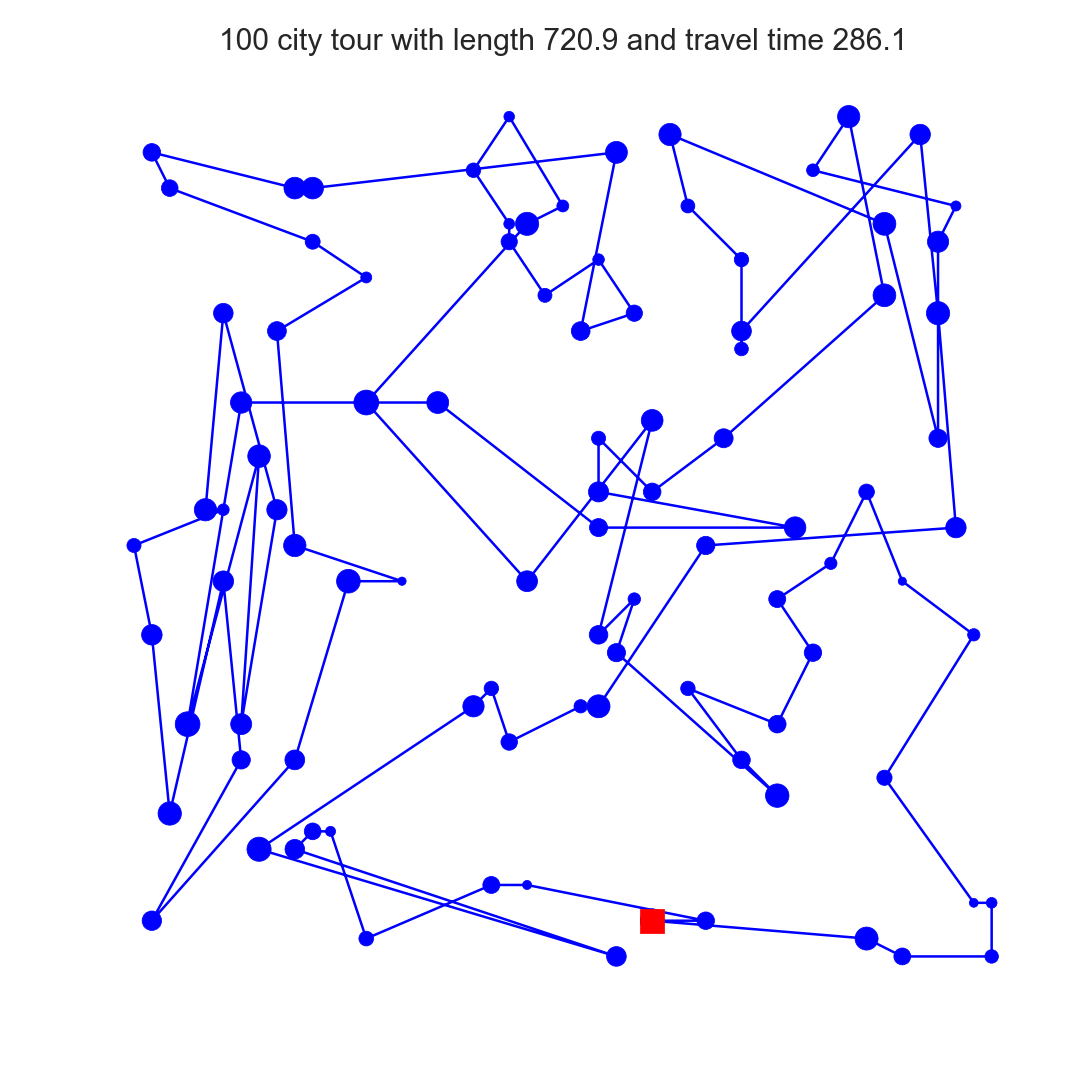

<IPython.core.display.Javascript object>


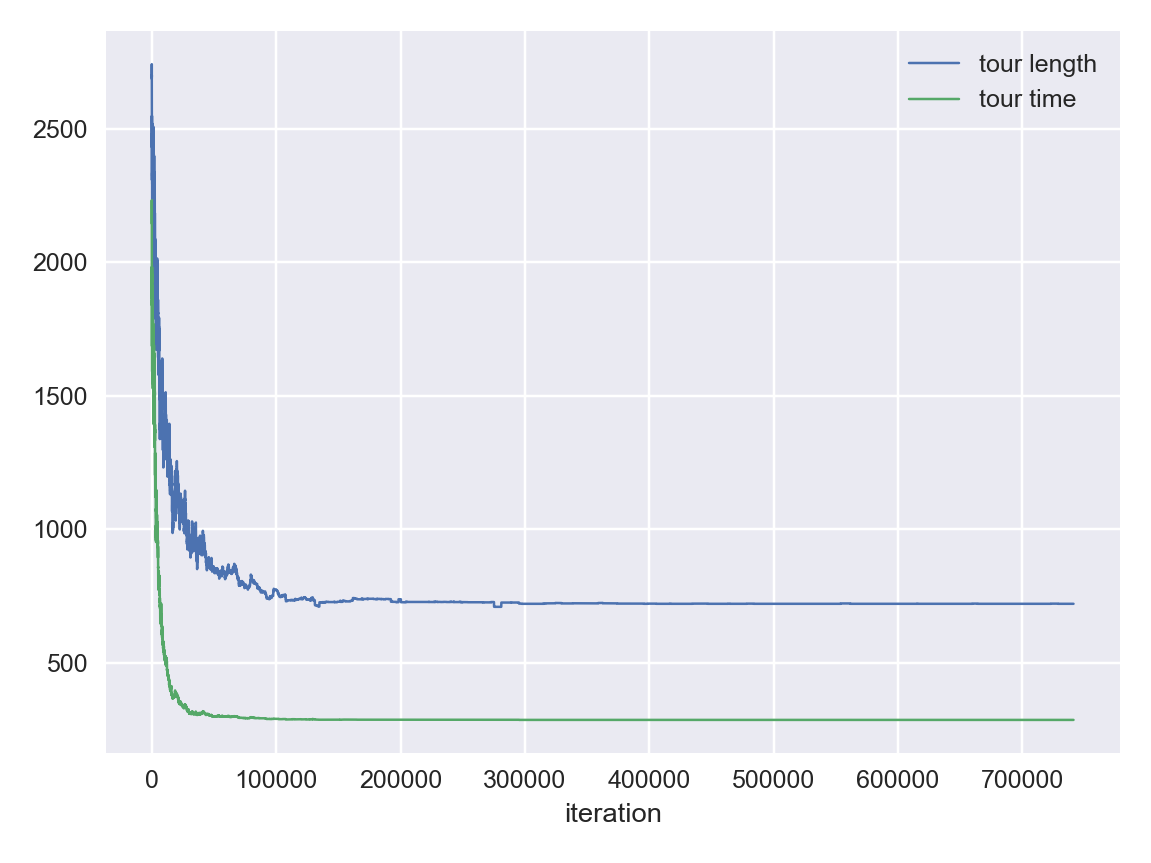

In [45]:
bmeta, bs, be, out = sa_tsp(tour_time, inits, 40, temp_func, length_func, change_tour)

plt.figure(figsize=(6,6))
plot_tsp(bs, mycities)
plt.tight_layout()

T_history = [e[0] for e in out]
tour_time_history = [e[2] for e in out]
tour_length_history = [tour_length(e[1]) for e in out]

plt.figure()
plt.plot(tour_length_history, lw=1, label='tour length')
plt.plot(tour_time_history, lw=1, label='tour time')
plt.xlabel('iteration')
# plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

The optimal solution found by minimizing the total time of travel is shown above. The tour length is 720.9 and travel time is 286.1. This is different from the result obtained by minimizing the total distance travelled. Now the travel time is small but the tour length is relatively big. Because of the existence of flight, paths between far apart large cities are more favored, and so the total distance travelled is big.   

The history of the tour length and tour time over iterations shows that while both are converging the tour time decreases faster than tour length. 

### 3. If changing the distance and population thresholds for the existence of a flight


frac accepted 0.026677646505218224 
total iterations 297515 
bmeta {'index': 147128, 'temp': 0.09903520314283058}


<IPython.core.display.Javascript object>


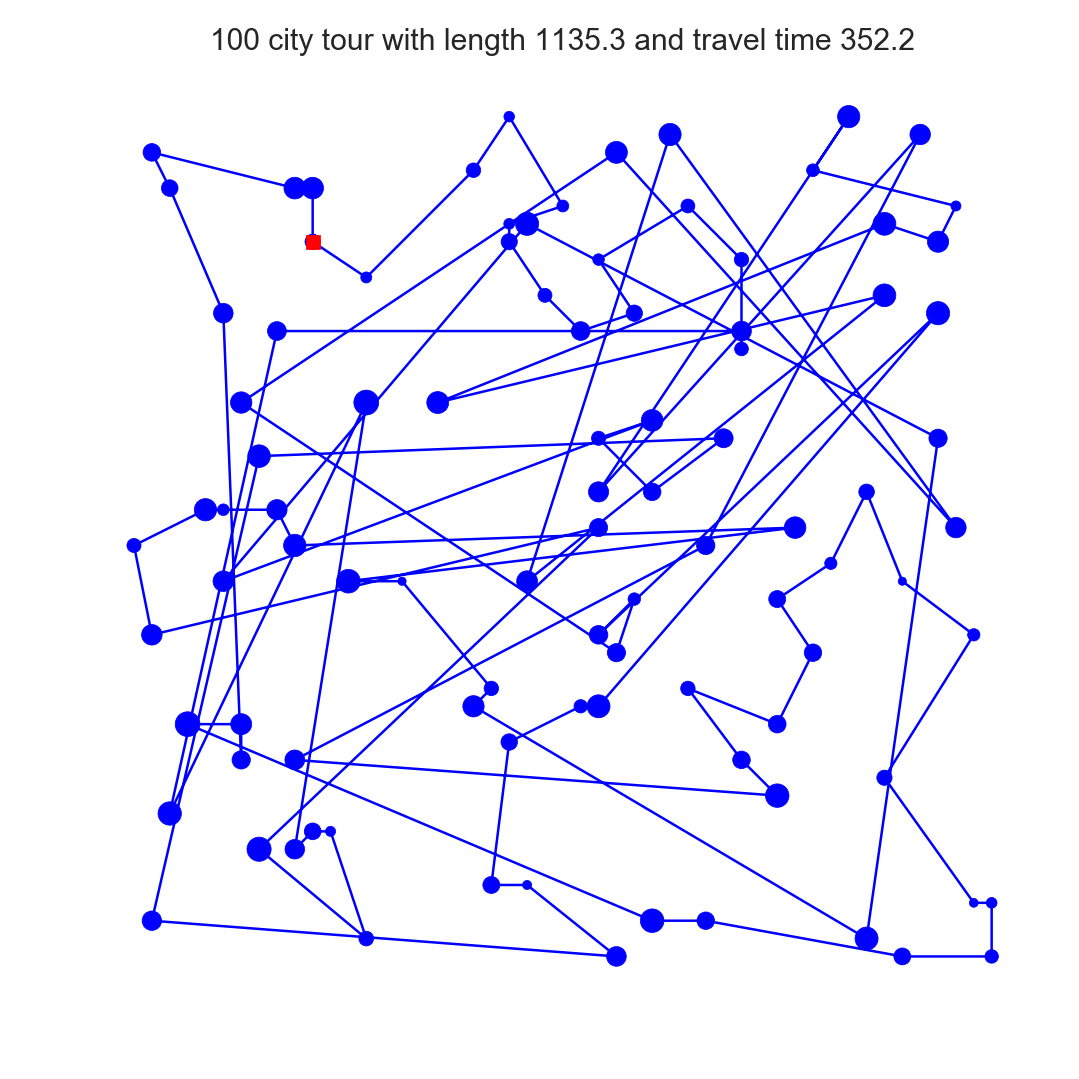

<IPython.core.display.Javascript object>


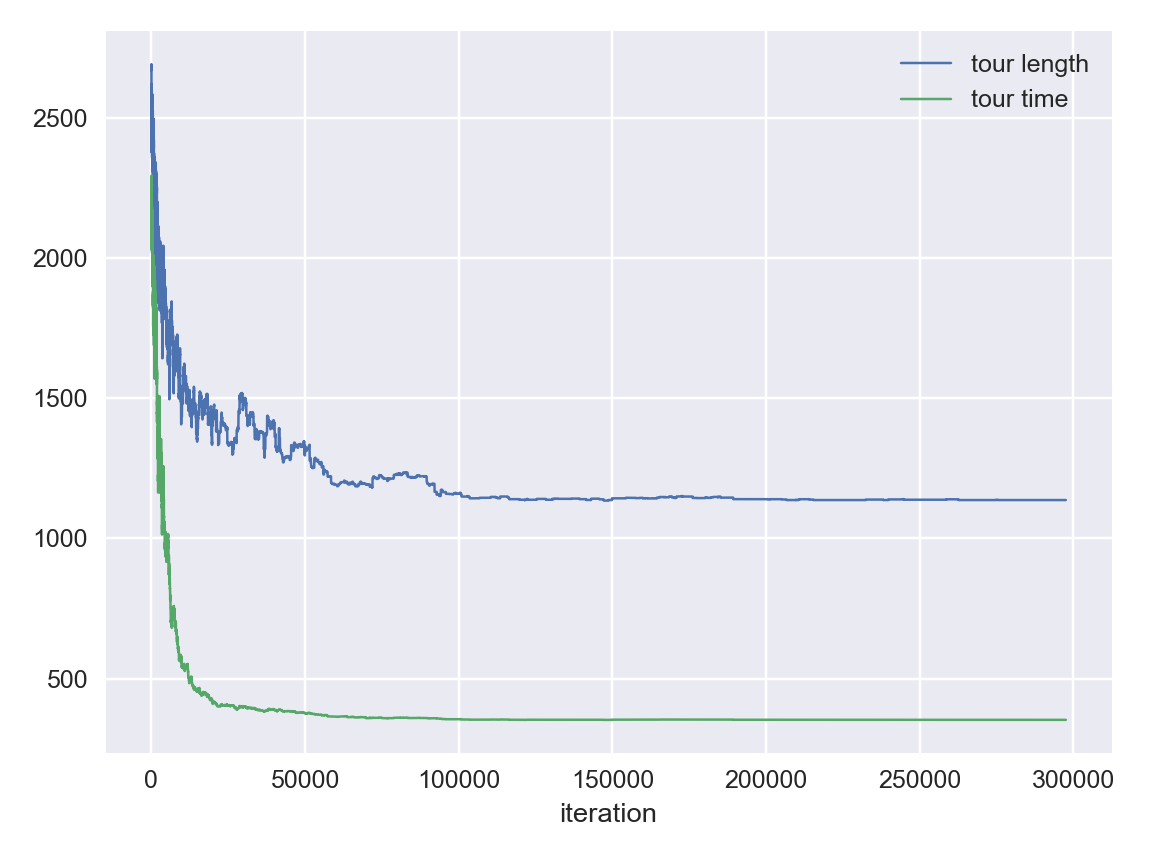

In [46]:
# High distance threshold
d_threshold = 25
p_threshold = 5
tour_time_new = functools.partial(tour_time, distance_threshold=d_threshold, population_threshold=p_threshold)

bmeta, bs, be, out = sa_tsp(tour_time_new, inits, 35, temp_func, length_func, change_tour)

plt.figure(figsize=(6,6))
plot_tsp(bs, mycities, tour_time_new)
plt.tight_layout()

T_history = [e[0] for e in out]
tour_time_history = [e[2] for e in out]
tour_length_history = [tour_length(e[1]) for e in out]

plt.figure()
plt.plot(tour_length_history, lw=1, label='tour length')
plt.plot(tour_time_history, lw=1, label='tour time')
plt.xlabel('iteration')
# plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()


frac accepted 0.032872292153336806 
total iterations 297515 
bmeta {'index': 127535, 'temp': 0.12379400392853822}


<IPython.core.display.Javascript object>


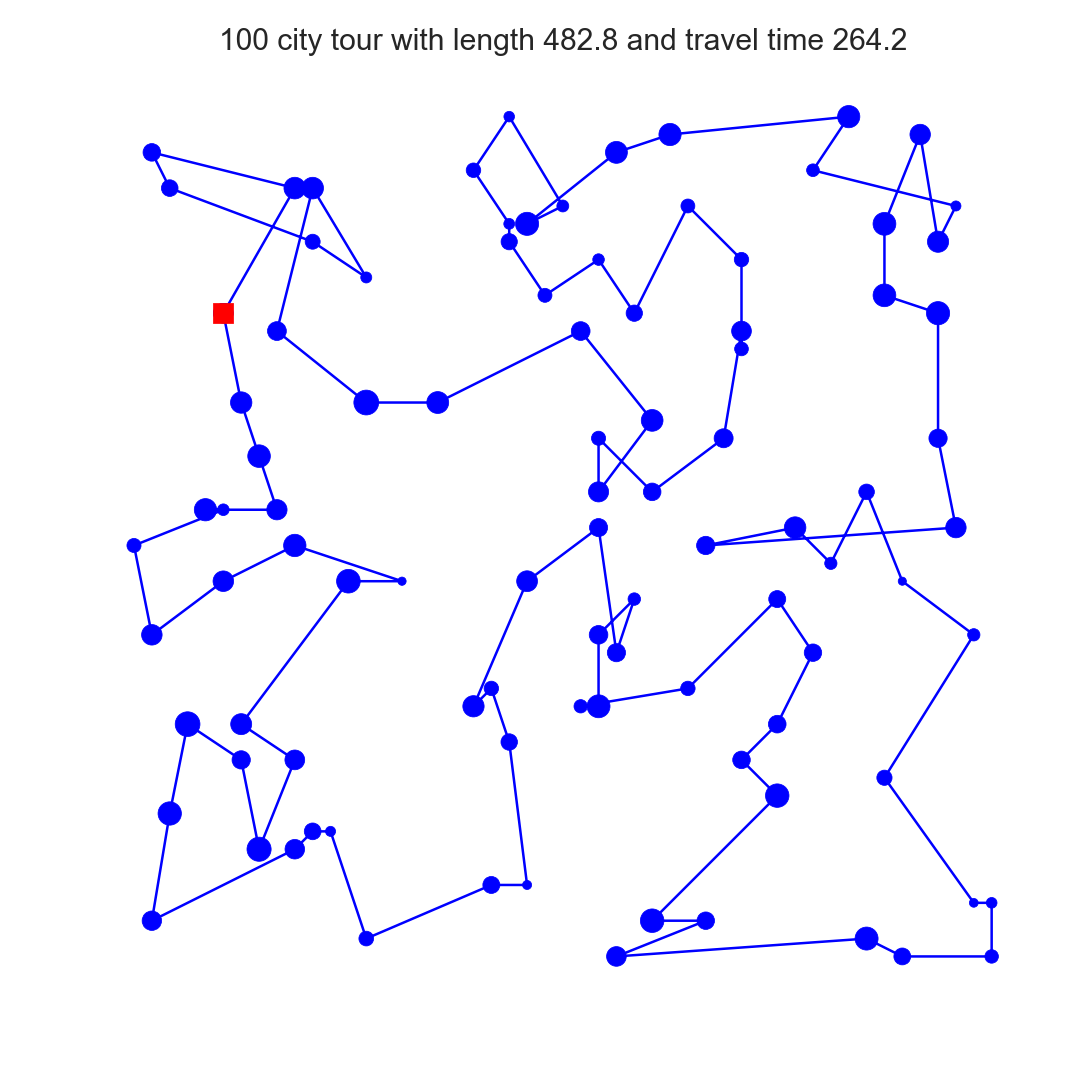

<IPython.core.display.Javascript object>


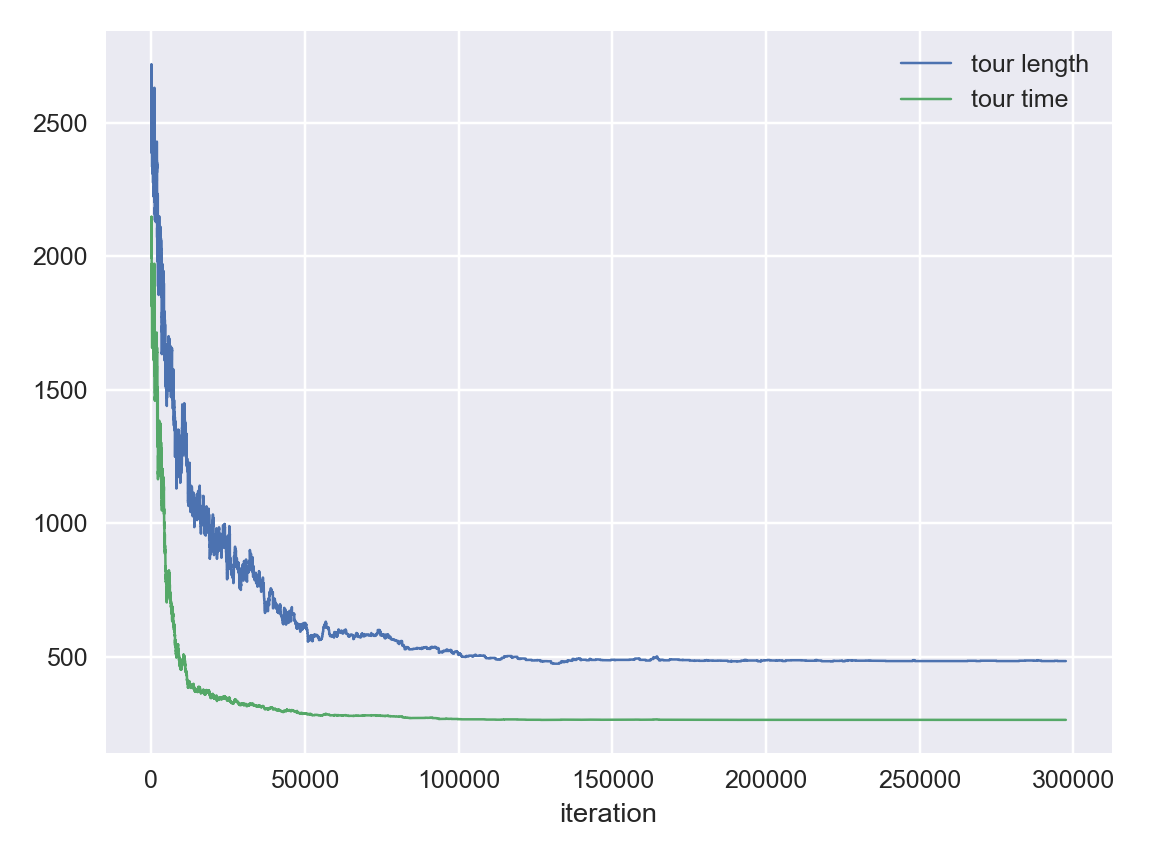

In [43]:
# Low distance threshold
d_threshold = 3
p_threshold = 5
tour_time_new = functools.partial(tour_time, distance_threshold=d_threshold, population_threshold=p_threshold)

bmeta, bs, be, out = sa_tsp(tour_time_new, inits, 35, temp_func, length_func, change_tour)

plt.figure(figsize=(6,6))
plot_tsp(bs, mycities, tour_time_new)
plt.tight_layout()

T_history = [e[0] for e in out]
tour_time_history = [e[2] for e in out]
tour_length_history = [tour_length(e[1]) for e in out]

plt.figure()
plt.plot(tour_length_history, lw=1, label='tour length')
plt.plot(tour_time_history, lw=1, label='tour time')
plt.xlabel('iteration')
# plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()


frac accepted 0.06054820765339563 
total iterations 297515 
bmeta {'index': 246382, 'temp': 0.06338253001141157}


<IPython.core.display.Javascript object>


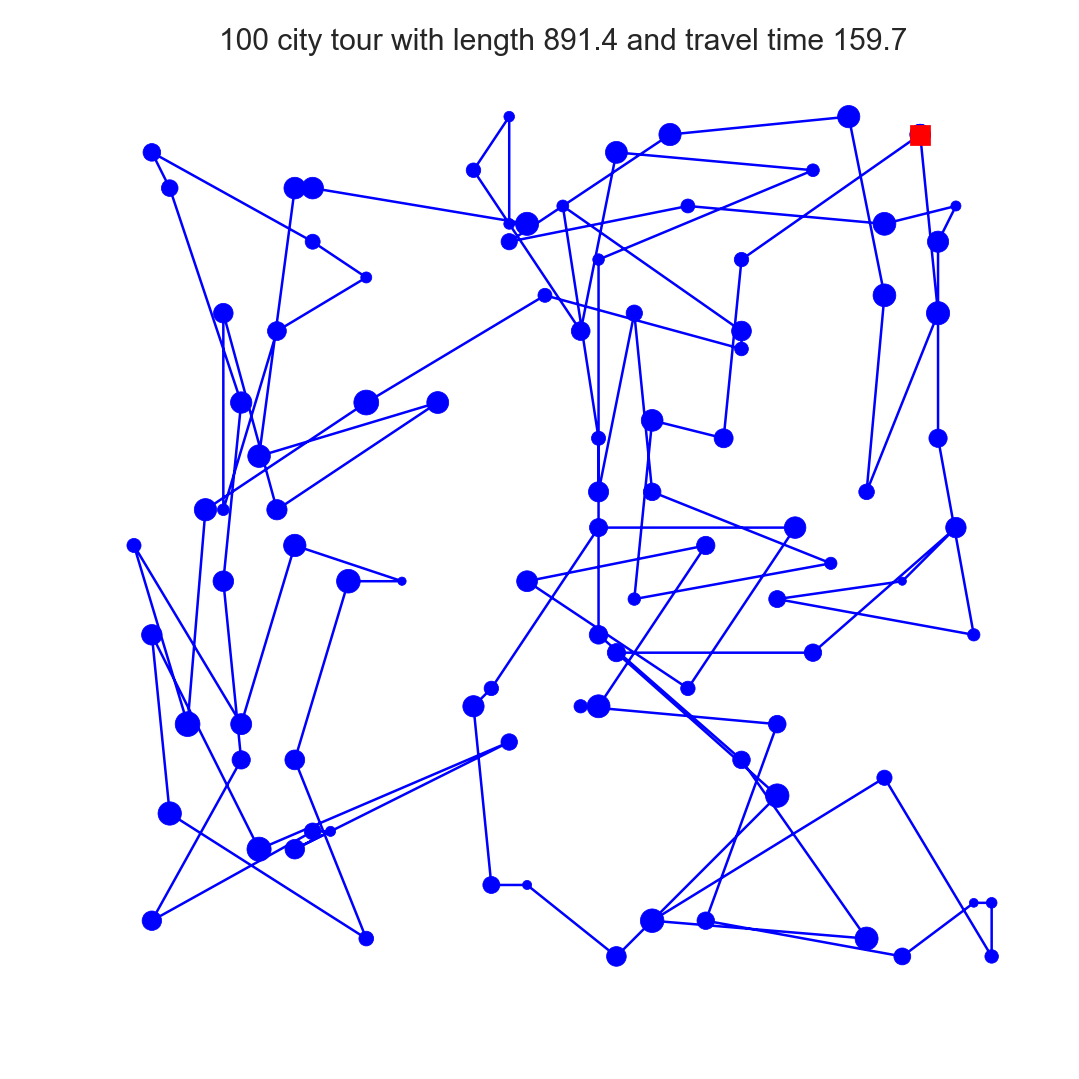

<IPython.core.display.Javascript object>


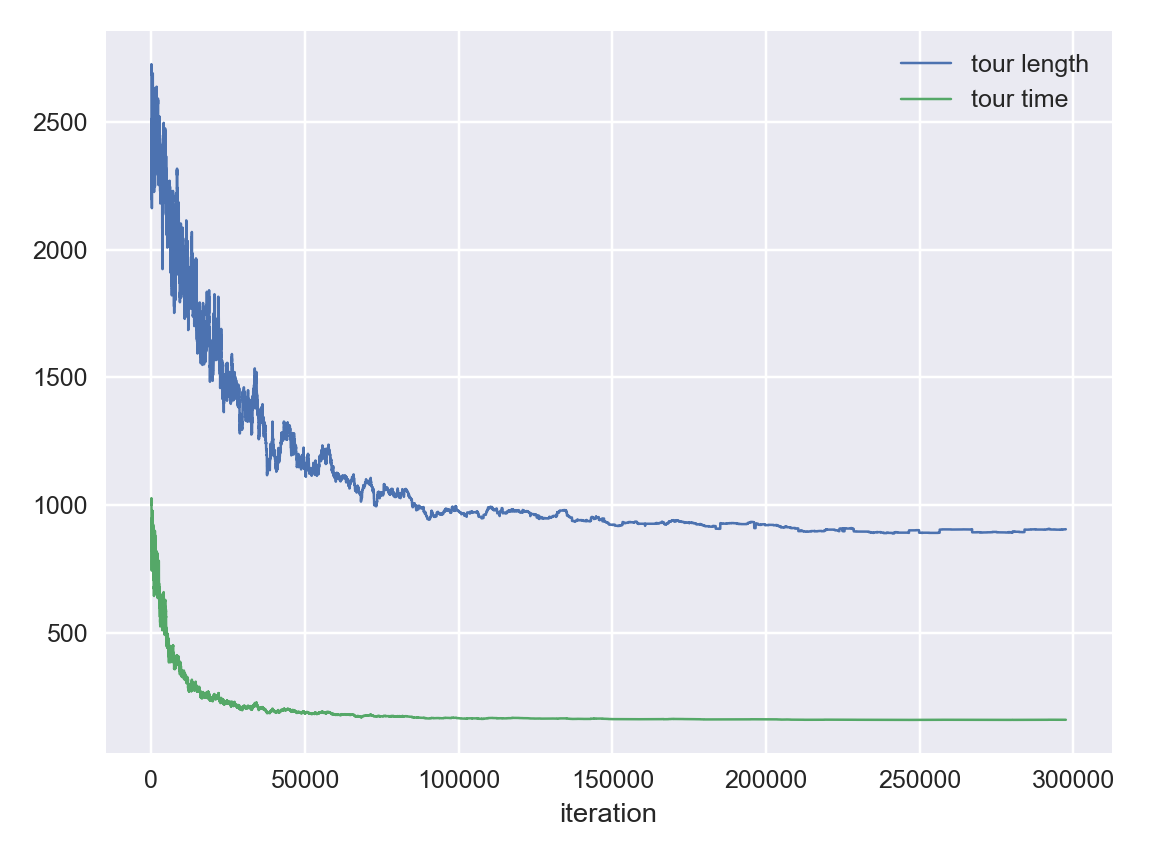

In [42]:
# Low population threshold
d_threshold = 10
p_threshold = 2
tour_time_new = functools.partial(tour_time, distance_threshold=d_threshold, population_threshold=p_threshold)

bmeta, bs, be, out = sa_tsp(tour_time_new, inits, 35, temp_func, length_func, change_tour)

plt.figure(figsize=(6,6))
plot_tsp(bs, mycities, tour_time_new)
plt.tight_layout()

T_history = [e[0] for e in out]
tour_time_history = [e[2] for e in out]
tour_length_history = [tour_length(e[1]) for e in out]

plt.figure()
plt.plot(tour_length_history, lw=1, label='tour length')
plt.plot(tour_time_history, lw=1, label='tour time')
plt.xlabel('iteration')
# plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()


frac accepted 0.041742149758454104 
total iterations 119232 
bmeta {'index': 106346, 'temp': 0.15474250491067276}


<IPython.core.display.Javascript object>


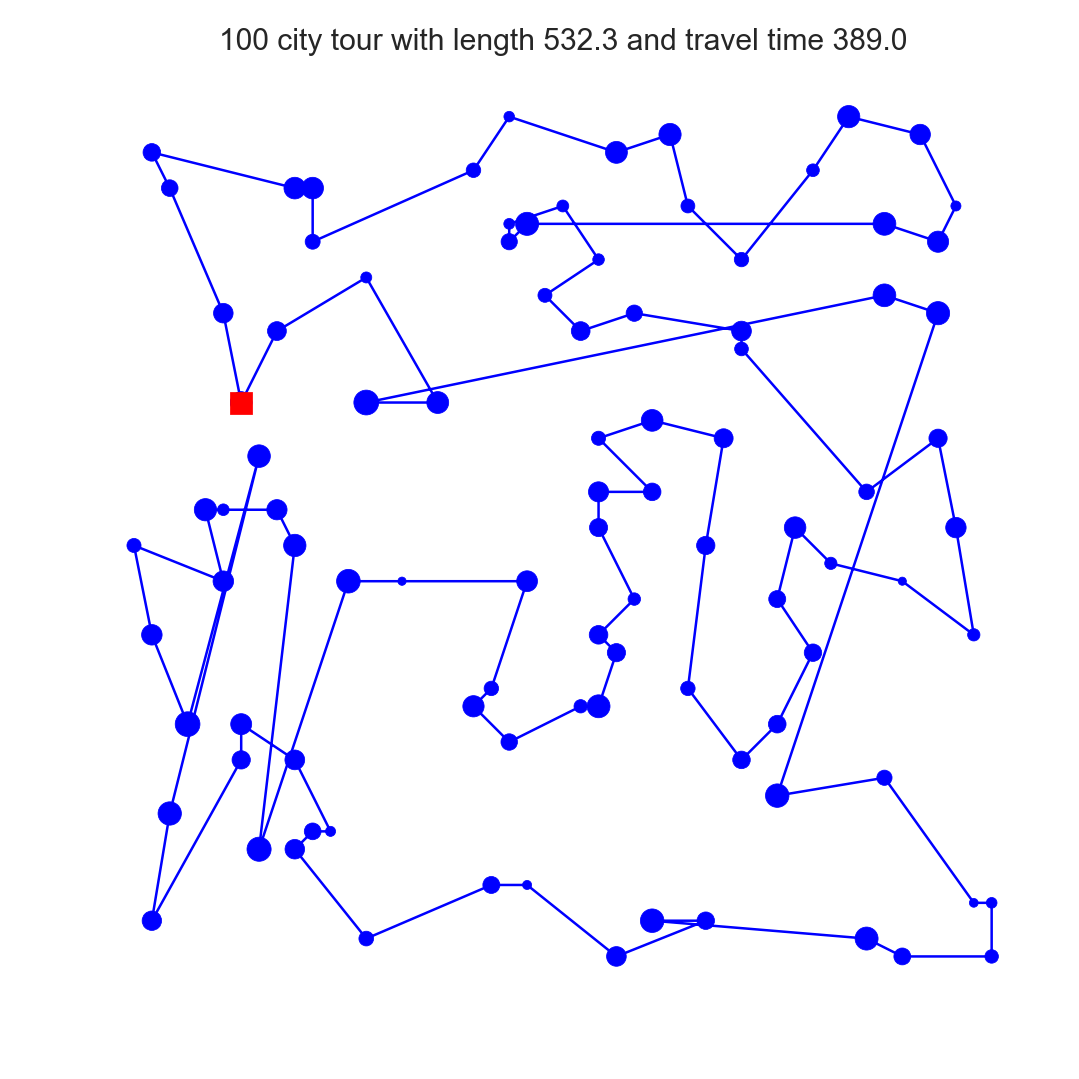

<IPython.core.display.Javascript object>


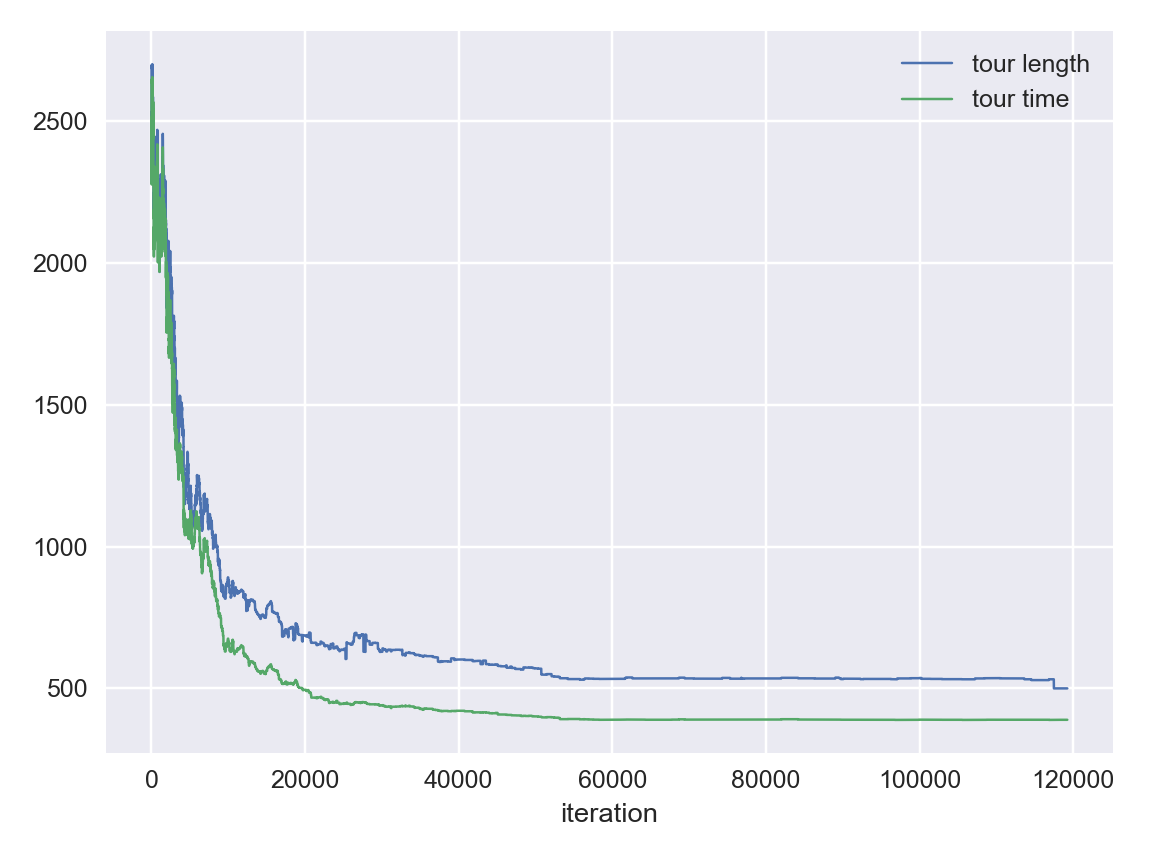

In [37]:
# High population threshold
d_threshold = 10
p_threshold = 8
tour_time_new = functools.partial(tour_time, distance_threshold=d_threshold, population_threshold=p_threshold)

bmeta, bs, be, out = sa_tsp(tour_time_new, inits, 30, temp_func, length_func, change_tour)

plt.figure(figsize=(6,6))
plot_tsp(bs, mycities, tour_time_new)
plt.tight_layout()

T_history = [e[0] for e in out]
tour_time_history = [e[2] for e in out]
tour_length_history = [tour_length(e[1]) for e in out]

plt.figure()
plt.plot(tour_length_history, lw=1, label='tour length')
plt.plot(tour_time_history, lw=1, label='tour time')
plt.xlabel('iteration')
# plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()

The solutions obtained by optimizing total time of travel with different distance and population thresholds are summarized as below:

|Distance threshold|Population threshold|Tour length|Travel time|
| :-------------: |:-------------:| -----:|------:|
| 10| 5| 720.9 |286.1|
| 25| 5| 1135.3 |352.2|
| 3 | 5| 482.8 |264.2|
|10|2|891.4|159.7|
|10|8| 532.3|389.0 |

In general, smaller distance threshold gives rise to shorter travel time and smaller tour length. Smaller population threshold gives tise to shorter travel time and larger tour length. 

***